# 1) Data Exploration

In [1]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import os
from pathlib import Path

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


## 1.1) Load Data

**All data**

WagonCab's engineering team stores all it's cab course history since 2009 in a massive Big Query table `wagon-public-datasets.taxifare.raw_all`. 
- This table contains `1.1 Million` for this challenge exactly, from **2009 to jun 2015**. 
- *(Note from Le Wagon: In reality, there is 55M rows but we limited that for cost-control in the whole module)*

**Training phase data**

- The training phase takes place in `2015-01-01`. We can't access any data beyond that date to train our model
- The datascientist's notebook hereby trains a ML model on a **200k randomly sampled subset** (so that everything fit in RAM memory on the Data Scientist's laptop)
- WagonCab's data-engineering team has created a `materialized view` of this `raw` table called `raw_200k` and given read access to the DataScientist for its training.

In [2]:
LOCAL_DATA_PATH = Path('~').joinpath(".lewagon", "mlops", "data").expanduser()
GCP_PROJECT_WAGON = "wagon-public-datasets"
BQ_DATASET = "taxifare"
DATA_SIZE = "200k"  # raw_200k is a randomly sampled materialized view from "raw_all" data table
MIN_DATE = '2009-01-01'
MAX_DATE = '2015-01-01'
COLUMN_NAMES_RAW = ('fare_amount',	'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count')


**Fill your `GCP_PROJECT` below 👇**, Then let's query the historical data (pre-2015), ordered by date (so as to train/test split chronologically more easily) !

In [3]:
GCP_PROJECT = "taxifare-379314"


In [4]:
query = f"""
    SELECT {",".join(COLUMN_NAMES_RAW)}
    FROM `{GCP_PROJECT_WAGON}`.{BQ_DATASET}.raw_{DATA_SIZE}
    WHERE pickup_datetime BETWEEN '{MIN_DATE}' AND '{MAX_DATE}'
    ORDER BY pickup_datetime
    """
print(query)



    SELECT fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
    FROM `wagon-public-datasets`.taxifare.raw_200k
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-01-01'
    ORDER BY pickup_datetime
    


Make the BigQuery call only if file does not already exist locally.  
Else, store locally as CSV to avoid calling BigQuery at each notebook run.

In [5]:
data_query_cache_path = Path(LOCAL_DATA_PATH).joinpath("raw", f"query_{MIN_DATE}_{MAX_DATE}_{DATA_SIZE}.csv")

if data_query_cache_path.is_file():
    print("load local file...")
    df = pd.read_csv(data_query_cache_path, parse_dates=['pickup_datetime'])

else:
    print("Querying Big Query server...")
    from google.cloud import bigquery

    client = bigquery.Client(project=GCP_PROJECT)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()

    df.to_csv(data_query_cache_path, header=True, index=False)


load local file...


In [6]:
df


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.20,2009-01-01 01:14:44+00:00,-73.982410,40.782397,-73.978177,40.783295,1
1,11.80,2009-01-01 03:51:05+00:00,-74.006797,40.716359,-73.978616,40.752433,2
2,26.60,2009-01-01 04:23:00+00:00,-73.982930,40.742167,-73.896904,40.843012,1
3,19.80,2009-01-01 04:49:52+00:00,-73.983822,40.729471,-73.982300,40.776622,2
4,3.40,2009-01-01 05:04:41+00:00,-74.013008,40.706021,-74.012851,40.702645,1
...,...,...,...,...,...,...,...
90738,14.50,2014-12-31 22:08:00+00:00,-73.980395,40.742585,-73.994602,40.769627,1
90739,9.50,2014-12-31 22:19:11+00:00,-73.962421,40.794752,-73.940646,40.814270,2
90740,74.16,2014-12-31 22:26:27+00:00,-73.783610,40.648637,-74.091878,40.626073,2
90741,8.50,2014-12-31 22:29:09+00:00,-73.995097,40.752067,-73.981982,40.766362,1


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90743 entries, 0 to 90742
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        90743 non-null  float64            
 1   pickup_datetime    90743 non-null  datetime64[ns, UTC]
 2   pickup_longitude   90743 non-null  float64            
 3   pickup_latitude    90743 non-null  float64            
 4   dropoff_longitude  90743 non-null  float64            
 5   dropoff_latitude   90743 non-null  float64            
 6   passenger_count    90743 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 4.8 MB


### 1.1.1) Compress Data

Let's compress our DataFrame by lowering its numeric `dtypes`
- from  `float64` to `float32`
- from `int64` to `int8`

To do so, we iterate on its columns, and for each one, reduce its `dtypes` as much as possible using [`pd.to_numeric`](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html)

**💡 1) Read more about `dtype` compression in the ML Ops - Train at Scale lecture on Kitt, "Appendix A1: Memory Optimization"**

**💡 2) Then, understand and execute the following code**

In [8]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')

    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df


In [9]:
df = compress(df, verbose=True)
df.head(1)


old dataframe size:  4.85 MB
optimized size by 48.0 %
new DataFrame size:  2.51  MB


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.2,2009-01-01 01:14:44+00:00,-73.982407,40.782398,-73.97818,40.783295,1


Let's check dtypes optimized

In [10]:
df.dtypes


fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                     int8
dtype: object

💡 Int8 is a bit too small for some scientific libraries, let's use int16

In [11]:
df.passenger_count = df.passenger_count.astype("int16")


💡 Next time, we can force dtypes directly **at loading time** as follow:

```python
query_job = client.query(query)
result = query_job.result() 
df = result.to_dataframe(dtypes=DTYPES_RAW)
```

In [12]:
DTYPES_RAW = {
    "key": "datetime64[ns, UTC]",
    "fare_amount": "float32",
    "pickup_datetime": "datetime64[ns, UTC]",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count": "int16"
}


## 1.2) Clean Data

In [13]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,90743.000000,90743.000000,90743.000000,90743.000000,90743.000000,90743.000000
mean,11.184035,-72.515381,39.943375,-72.532669,39.941231,1.683149
std,9.550824,10.696279,8.880565,12.055413,8.878703,1.303741
min,-2.500000,-736.583313,-74.009773,-1749.704590,-74.015160,0.000000
25%,6.000000,-73.992065,40.735081,-73.991379,40.734219,1.000000
50%,8.500000,-73.981850,40.752686,-73.980202,40.753307,1.000000
75%,12.500000,-73.967209,40.767073,-73.963799,40.767990,2.000000
max,208.000000,169.972763,1963.515869,169.972763,1963.515869,6.000000


In [14]:
df.shape


(90743, 7)

remove redundant rows

In [15]:
df = df.drop_duplicates()
df.shape


(90743, 7)

Remove buggy transactions

In [16]:
df = df.dropna(how='any', axis=0)
print(df.shape)
df = df[df.passenger_count > 0]
df = df[df.fare_amount > 0]
print(df.shape)


(90743, 7)
(90422, 7)


Remove geographically irrelevant transactions (rows)

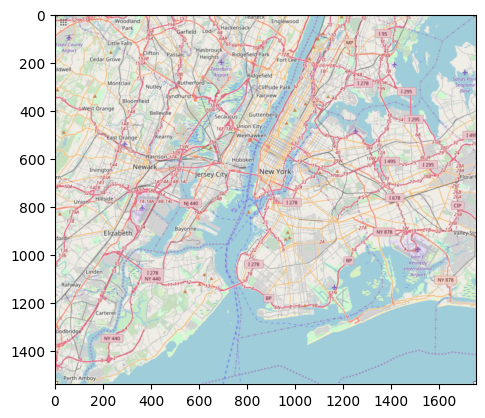

In [17]:
# Let's check NYC bouding boxes
# Load image of NYC map
bounding_boxes = (-74.3, -73.7, 40.5, 40.9)

url = 'https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/nyc_-74.3_-73.7_40.5_40.9.png'
nyc_map = np.array(PIL.Image.open(urllib.request.urlopen(url)))

plt.imshow(nyc_map);


In [18]:
df = df[df["pickup_latitude"].between(left=40.5, right=40.9)]
df = df[df["dropoff_latitude"].between(left=40.5, right=40.9)]
df = df[df["pickup_longitude"].between(left=-74.3, right=-73.7)]
df = df[df["dropoff_longitude"].between(left=-74.3, right=-73.7)]


In [19]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,88381.000000,88381.000000,88381.000000,88381.000000,88381.000000,88381.000000
mean,11.128640,-73.975761,40.750935,-73.974655,40.751213,1.688689
std,9.218863,0.033885,0.026704,0.033909,0.030540,1.301394
min,2.500000,-74.244141,40.502598,-74.275803,40.501408,1.000000
25%,6.000000,-73.992287,40.736656,-73.991570,40.735806,1.000000
50%,8.500000,-73.982124,40.753403,-73.980698,40.753948,1.000000
75%,12.500000,-73.968452,40.767433,-73.965591,40.768276,2.000000
max,158.250000,-73.702583,40.893471,-73.700836,40.898937,6.000000


In [20]:
# Let's cap training set to reasonable values
df = df[df.fare_amount < 400]
df = df[df.passenger_count < 8]


In [21]:
df


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.200000,2009-01-01 01:14:44+00:00,-73.982407,40.782398,-73.978180,40.783295,1
1,11.800000,2009-01-01 03:51:05+00:00,-74.006798,40.716358,-73.978615,40.752434,2
2,26.600000,2009-01-01 04:23:00+00:00,-73.982933,40.742168,-73.896904,40.843014,1
3,19.799999,2009-01-01 04:49:52+00:00,-73.983826,40.729469,-73.982300,40.776623,2
4,3.400000,2009-01-01 05:04:41+00:00,-74.013008,40.706020,-74.012848,40.702644,1
...,...,...,...,...,...,...,...
90738,14.500000,2014-12-31 22:08:00+00:00,-73.980392,40.742584,-73.994598,40.769627,1
90739,9.500000,2014-12-31 22:19:11+00:00,-73.962418,40.794750,-73.940643,40.814270,2
90740,74.160004,2014-12-31 22:26:27+00:00,-73.783607,40.648636,-74.091881,40.626072,2
90741,8.500000,2014-12-31 22:29:09+00:00,-73.995094,40.752068,-73.981979,40.766361,1


## 1.3) Visualize Data

Text(0.5, 1.0, 'Histogram')

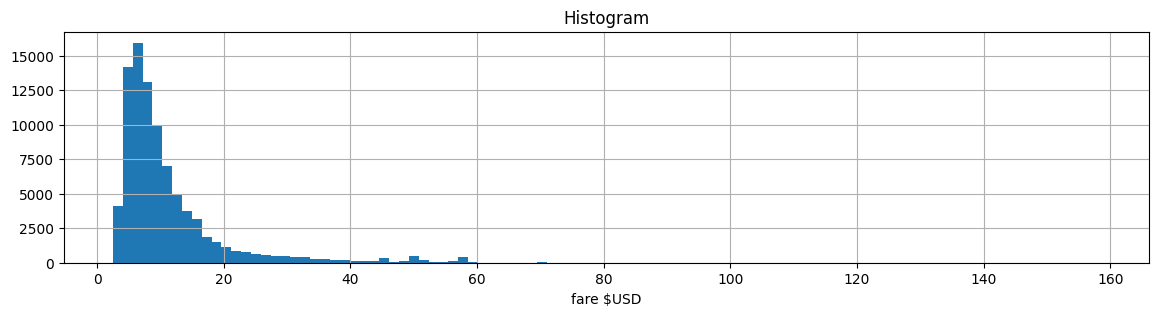

In [22]:
# Plot histogram of fare
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')


In [23]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))

    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='red', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='blue', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)


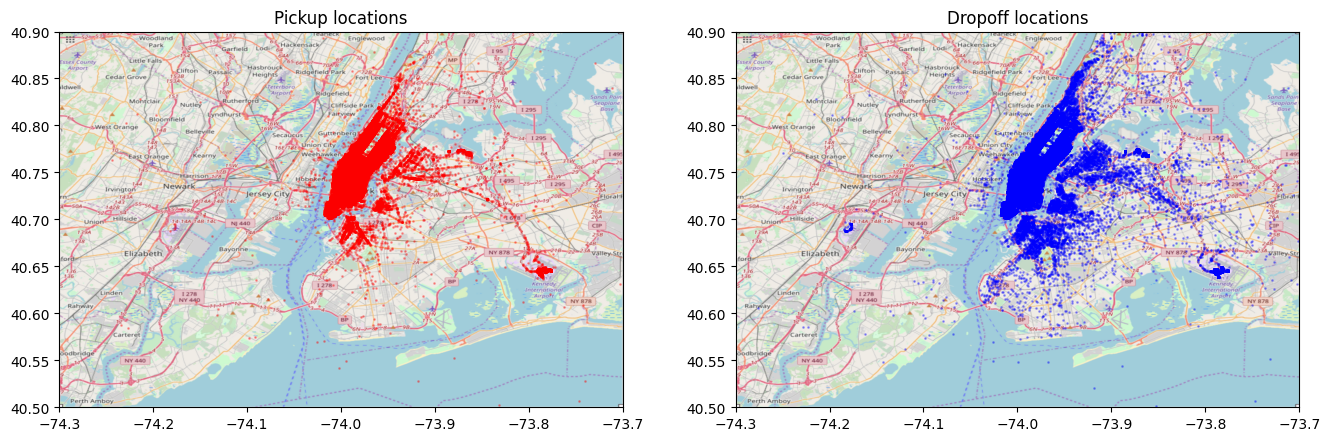

In [24]:
# Plot training data on map
plot_on_map(df, bounding_boxes, nyc_map, s=1, alpha=0.3)


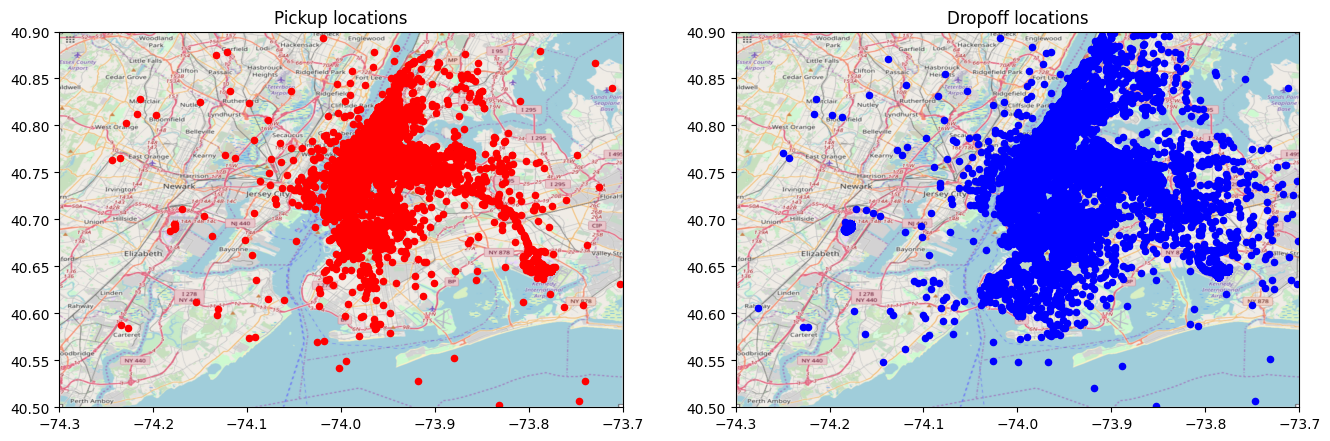

In [25]:
plot_on_map(df, bounding_boxes, nyc_map, s=20, alpha=1.0)


In [26]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    def select_within_boundingbox(df, BB):
        return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
            (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
            (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
            (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c="red", s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c="blue", s=0.01, alpha=0.5)


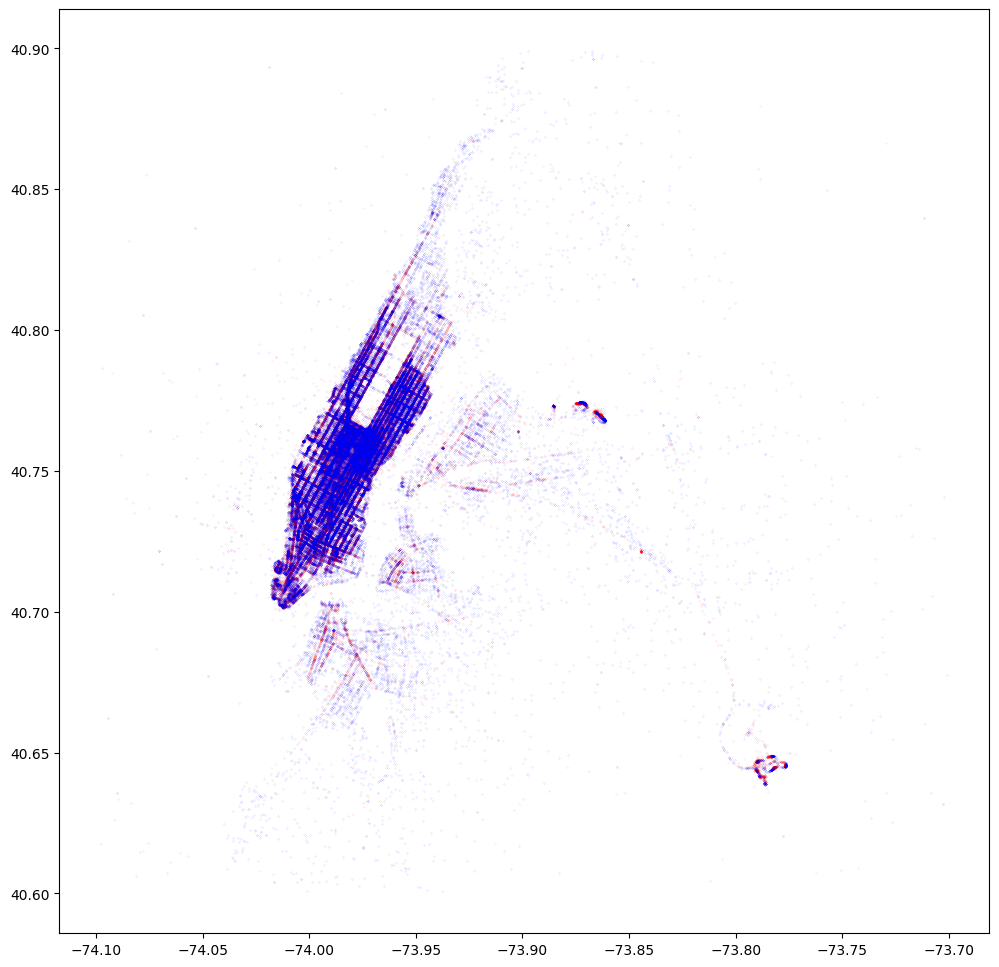

In [27]:
plot_hires(df, (-74.1, -73.7, 40.6, 40.9))


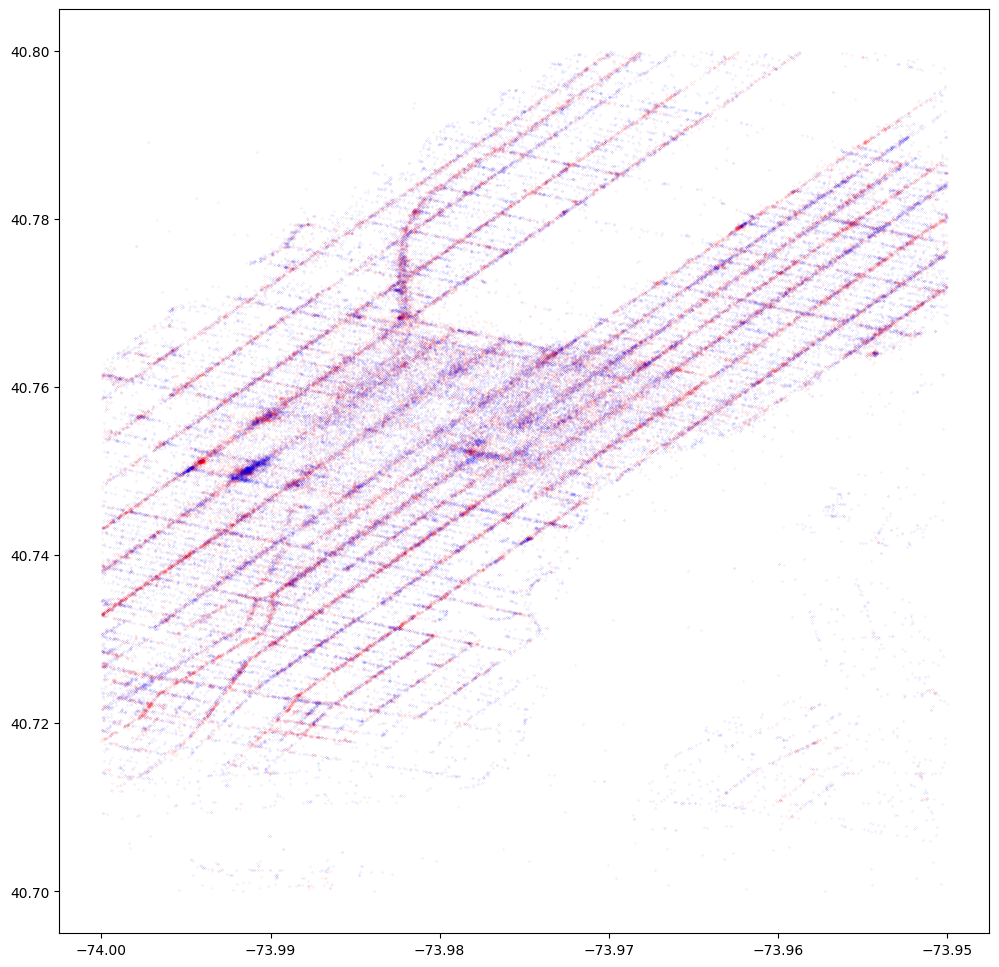

In [28]:
plot_hires(df, (-74, -73.95, 40.7, 40.8))


### 1.4) Baseline Score  - Preliminary Intuitions

A baseline model should at least take into account the most obvious feature: the distance between `pickup` and `dropoff`.

The correct distance metric is appropriately named "Manhattan distance" (L1 distance), which computes the sum of horizontal and vertical distances between two points, instead of the diagonal (Euclidean, L2) distance.

In [29]:
import math

def manhattan_distance(start_lat: float, start_lon: float, end_lat: float, end_lon: float) -> float:
    """
    Calculate the Manhattan distance between in km two points on the earth (specified in decimal degrees).
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = math.radians(start_lat), math.radians(start_lon)
    lat_2_rad, lon_2_rad = math.radians(end_lat), math.radians(end_lon)

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = abs(dlon_rad) + abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    return manhattan_km


In [30]:
%%time
df.apply(lambda row: manhattan_distance(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)


CPU times: user 1.75 s, sys: 29.5 ms, total: 1.78 s
Wall time: 1.78 s


0         0.569667
1         7.145228
2        20.779484
3         5.412897
4         0.393210
           ...    
90738     4.586604
90739     4.591694
90740    36.787424
90741     3.047697
90742     3.395521
Length: 88381, dtype: float64

☝️ The following code takes a while and is not optimized.

Applying a mapping function row-by-row on a DataFrame is a very bad engineering practice, as DataFrames are stored in memory "column-by-column". We talk about "column-major" data storage formats. 

`df.apply(..., axis=1)` is equivalent to a python `for` loop, and does not harness NumPy's vectorized operations.

👇 Let's vectorize our code instead! Notice the improvement by a factor of several hundred 💪

In [31]:
def manhattan_distance_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the Manhattan distance in km between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    return manhattan_km


In [32]:
%%time
manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")


CPU times: user 2.76 ms, sys: 412 µs, total: 3.17 ms
Wall time: 2.76 ms


0         0.569232
1         7.145590
2        20.780197
3         5.412451
4         0.393412
           ...    
90738     4.586134
90739     4.591830
90740    36.786667
90741     3.047423
90742     3.396025
Length: 88381, dtype: float32

Text(0.5, 1.0, 'distance (km)')

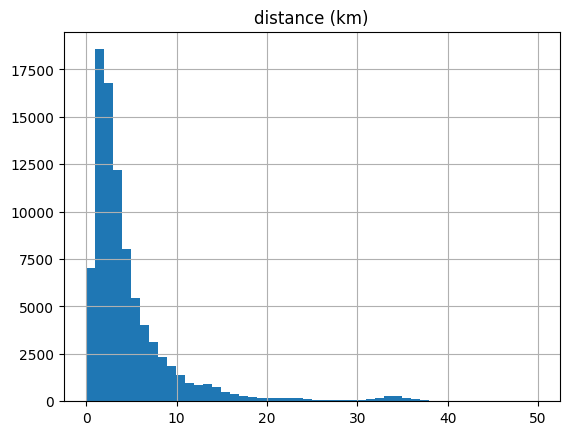

In [33]:
df['distance'] = manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")
df['distance'].hist(bins=50)
plt.title("distance (km)")


Let's drop the `distance` column we added manually, and create a true preprocessing pipeline now

In [34]:
df = df.drop(columns=['distance'])
df.shape


(88381, 7)

# 2) Train/Val/Test Split

🚨 We're dealing with timestamped data:
- It's important to split train/val/test in a **chronological** manner.
- We don't want to hold too long val or tests sets: macro-economic conditions are changing fast in real life!
- The smaller the `split_ratio`, the more often we'll have to re-train our model
- With a dataset of 6 years, it's perfectly fine to keep 1 month ahead of val, 1 month ahead for test
- In production, this means we shouldn't trust our model performance to extend beyond 1 month in the future

In [35]:
split_ratio = 0.02 # ~1 month for val, ~1 month for test

test_length = int(len(df) * split_ratio)
val_length = int((len(df)-test_length) * split_ratio)
train_length = len(df) - val_length - test_length

df_train = df.iloc[:train_length, :].sample(frac=1) # Shuffle datasets to improve training
df_val = df.iloc[train_length: train_length + val_length, :].sample(frac=1)
df_test = df.iloc[train_length+val_length:, :].sample(frac=1)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

assert len(df_train) + len(df_val) + len(df_test) == len(df)


(84882, 7)
(1732, 7)
(1767, 7)


In [36]:
print(df_train.pickup_datetime.min())
print(df_train.pickup_datetime.max())
print('---')
print(df_val.pickup_datetime.min())
print(df_val.pickup_datetime.max())
print('---')
print(df_test.pickup_datetime.min())
print(df_test.pickup_datetime.max())


2009-01-01 01:14:44+00:00
2014-09-29 21:52:00+00:00
---
2014-09-30 00:09:00+00:00
2014-11-14 01:10:00+00:00
---
2014-11-14 02:00:00+00:00
2014-12-31 23:49:25+00:00


In [37]:

X = df.drop("fare_amount", axis=1)
y = df[["fare_amount"]]

X_train = df_train.drop("fare_amount", axis=1)
y_train = df_train[["fare_amount"]]

X_val = df_val.drop("fare_amount", axis=1)
y_val = df_val[["fare_amount"]]

X_test = df_test.drop("fare_amount", axis=1)
y_test = df_test[["fare_amount"]]


### Simple Baseline: $price = a * distance + b $

In [38]:
distances_train = np.array(manhattan_distance_vectorized(X_train, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_val = np.array(manhattan_distance_vectorized(X_val, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))
distances_test = np.array(manhattan_distance_vectorized(X_test, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"))


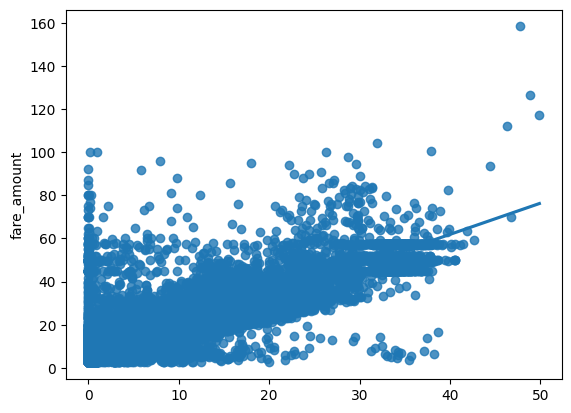

In [39]:
sns.regplot(x=distances_train, y=y_train);


In [40]:
from scipy.stats import pearsonr

pearson, p_value = pearsonr(distances_train, y_train)
print(f'{pearson=}')
print(f'{p_value=}')


pearson=array([0.8636389105298934], dtype=object)
p_value=0.0


In [41]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
baseline_model.fit(distances_train[:, None], y_train)


LinearRegression()

In [42]:
baseline_pred_val = baseline_model.predict(distances_val[:, None])
baseline_pred_test = baseline_model.predict(distances_test[:, None])
baseline_mae_val = np.mean(np.abs(baseline_pred_val - y_val), axis=0)
baseline_mae_test = np.mean(np.abs(baseline_pred_test - y_test), axis=0)

print(f'mean taxifare prices on train set = {round(float(np.mean(y_train, axis=0)),2)} $')
print(f'🎯 baseline MAE on val set = {round(float(baseline_mae_val),2)} $')
print(f'🎯 baseline MAE on test set = {round(float(baseline_mae_test),2)} $')


mean taxifare prices on train set = 11.04 $
🎯 baseline MAE on val set = 2.85 $
🎯 baseline MAE on test set = 2.88 $


# 3) Preprocessing Pipeline

We are given a dataset with only 5 features (passengers + lon/lat), and potentially dozens of millions of rows.

👉 It makes perfect sense to create a lot of "engineered" features such as "hour of the day"  
- Hundreds of them would cause no problem because the huge number of rows will allow our model to learn all weights associated with these multiple features
- A dense, Deep Learning network will be well-suited for such a case

❗️ The proposed preprocessor below outputs a **fixed number of features** (65) that is **independent of the training set**. You will see that it will come in handy when scaling it up to hundreds of millions of rows

## 3.1) Passenger Preprocessors

Let's analyze passenger numbers

In [43]:
df.passenger_count


0        1
1        2
2        1
3        2
4        1
        ..
90738    1
90739    2
90740    2
90741    1
90742    1
Name: passenger_count, Length: 88381, dtype: int16

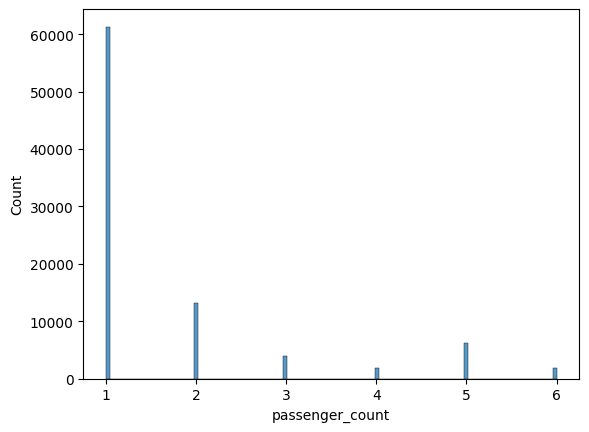

In [44]:
sns.histplot(data=df, x="passenger_count");


In [45]:
# PASSENGER PIPE
p_min = 1.
p_max = 8.
passenger_pipe = FunctionTransformer(lambda p: (p-p_min)/(p_max-p_min))


In [46]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
    ],
)
preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f12f7e231c0>),
                                 ['passenger_count'])])

In [47]:
pd.DataFrame(preprocessor.fit_transform(X_train))


,0
0,0.000000
1,0.714286
2,0.000000
3,0.714286
4,0.000000
...,...
84877,0.000000
84878,0.000000
84879,0.000000
84880,0.000000


## 3.2) Time Preprocessor

let's extract interesting attributes from the `pickup_datetime`
- hour of the day
- day of the week
- month of the year
- number of days since 2009 (it may encode inflation parameters)

In [48]:
import math

def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    timedelta = (X["pickup_datetime"] - pd.Timestamp('2009-01-01T00:00:00', tz='UTC'))/pd.Timedelta(1,'D')

    pickup_dt = X["pickup_datetime"].dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)

    return np.stack([hour_sin, hour_cos, dow, month, timedelta], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "timedelta"]).head()


,hour_sin,hour_cos,dow,month,timedelta
0,-0.866025,0.500000,2.0,12.0,0.051898
1,-0.500000,0.866025,2.0,12.0,0.160475
2,-0.258819,0.965926,2.0,12.0,0.182639
3,-0.258819,0.965926,2.0,12.0,0.201296
4,0.000000,1.000000,3.0,1.0,0.211586


Then, we one-hot-encode `["day of week", "month"]` by forcing all 24*7 combinations of categories to be always present in `X_processed` 

(remember we want a fixed size for `X_processed` at the end)

In [49]:
time_categories = [
        np.arange(0, 7, 1),  # days of the week from 0 to 6
        np.arange(1, 13, 1)  # months of the year from 1 to 12
    ]

OneHotEncoder(categories=time_categories, sparse_output=False)\
    .fit_transform(X_time_processed[:,[2,3]]) # column index [2,3] for ['dow', 'month'] !


array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

And combine this with a sort of "Min-Max" re-scaling of the `timedelta` column

In [50]:
print(X_time_processed[:,-1].min())
print(X_time_processed[:,-1].max())


0.05189814814814815
2190.992650462963


In [51]:
timedelta_min = 0
timedelta_max = 2190 # Our model may extend in the future. No big deal if the scaled data extend slightly beyond 1.0


In [52]:
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2, 3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - timedelta_min) / (timedelta_max - timedelta_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
    ],
)

preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f12f7e231c0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f12ef764c10>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(categories=[array([0, 1, 2, 3, 4, 5, 6]),
                                                                                                             array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])],
                                                                                                 handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('functiontransformer',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x7f1325485900>),
                                                                                   [4])]))]),
                                 ['pickup_datetime'])])

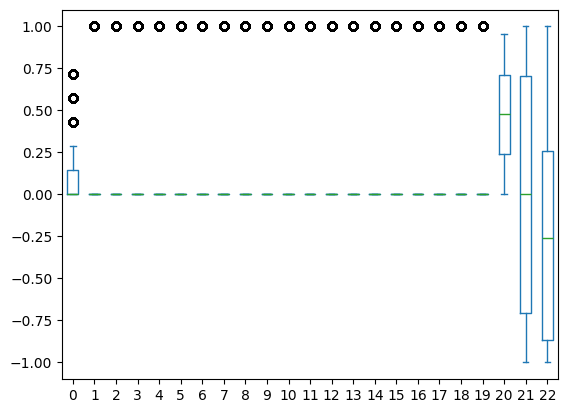

In [53]:
pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');


☝️ 23 features approximately centered and scaled

## 3.3) Distance Pipeline

Let's add both the haversine and Manhattan distances as features

In [54]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]


In [55]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and Manhattan distances between two points (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in Km
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius

    return dict(
        haversine = haversine_km,
        manhattan = manhattan_km
    )


In [56]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:
    assert isinstance(X, pd.DataFrame)
    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances


,haversine,manhattan
0,0.369161,0.569232
1,4.661616,7.145590
2,13.349266,20.780197
3,5.244656,5.412451
4,0.375439,0.393412
...,...,...
90738,3.236299,4.586134
90739,2.840849,4.591830
90740,26.132246,36.786667
90741,1.935356,3.047423


In [57]:
dist_min = 0
dist_max = 100


In [58]:
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
    )
distance_pipe


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function transform_lonlat_features at 0x7f12f7d99cf0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function <lambda> at 0x7f12f7d99b40>))])

In [59]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor


ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f12f7e231c0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f12ef764c10>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('oneho...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x7f1325485900>),
                                                                                   [4])]))]),
                                 ['pickup_datetime']),
                                ('dist_preproc',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x7f12f7d99cf0>)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f12f7d99b40>))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

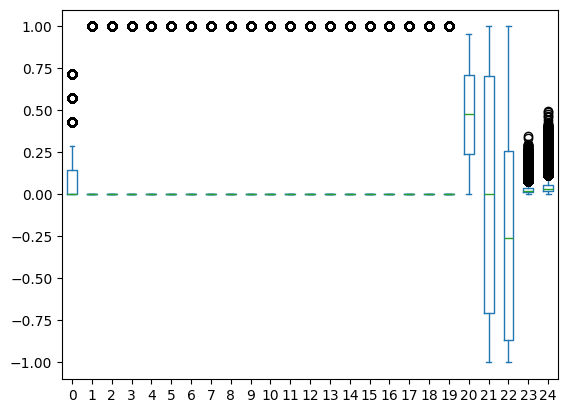

In [60]:
X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');


☝️ 25 features, approximately scaled

## 3.4) GeoHasher

Finally, let's add information about **districts**! 

Some might be more expensive than others to go to/depart from (e.g. JFK airport!)

To _bucketize_ geospatial information, we'll use `pygeohash`

In [61]:
import pygeohash as gh


💡 pygeohash converts (lat,lon) into geospacial "squared buckets" of chosen precisions. The more precision you ask, the more "buckets" possibility there is!

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/geohashes.png">

In [62]:
x0 = X_train.iloc[0,:]
(x0.pickup_latitude, x0.pickup_longitude)


(40.766705, -73.95418)

In [63]:
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=3))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=4))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=5))


dr5
dr5r
dr5rv


👇 Let's apply it to ALL of our data set (note that this preprocessing may take a very long time!)

In [64]:
def compute_geohash(X:pd.DataFrame, precision:int = 5) -> np.ndarray:
    """
    Add a geohash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]


In [65]:
compute_geohash(X_train)


,geohash_pickup,geohash_dropoff
69718,dr5rv,dr5ru
85925,dr5rv,dr72h
40161,dr5x1,dr72h
76863,dr5re,dr5rs
73025,dr5re,dr5re
...,...,...
7996,dr5rs,dr5rs
33359,dr5ru,dr5ru
33249,dr5ru,dr5ru
76354,dr5ru,dr5rs


☝️ Notice that this time, we have no choice but to apply `pygeohash` row by row with `df.apply(axis=1)`, and it takes a while to compute.

This is the danger of relying on an external Python library that is not always vectorized. 

👇 What are the most common districts?

In [66]:
all_geohashes = pd.concat([
    X_train.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=4), axis=1),
    X_train.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=4), axis=1),
])


9


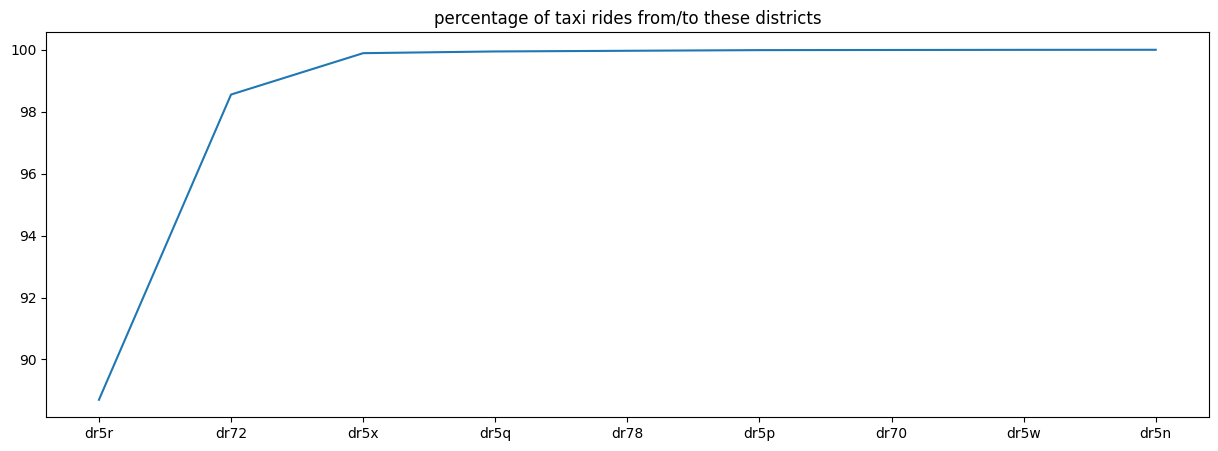

In [67]:
print(len(all_geohashes.value_counts()))
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(all_geohashes.value_counts()[:20])/(2*len(X_train))*100)
plt.title("percentage of taxi rides from/to these districts");


☝️ Only the first 20 districts matter. We can one-hot encode them.

In [68]:
most_important_geohash_districts = np.array(all_geohashes.value_counts()[:20].index)
most_important_geohash_districts


array(['dr5r', 'dr72', 'dr5x', 'dr5q', 'dr78', 'dr5p', 'dr70', 'dr5w',
       'dr5n'], dtype=object)

In [69]:
# Let's hard-code below the 20 most frequent district GeoHashes of precision 5,
# covering about 99% of all dropoff/pickup locations.
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]


Let's one-hot encode each GeoHash in one of the top-20 different buckets listed above


In [70]:
geohash_categories = [
    most_important_geohash_districts,  # pickup district list
    most_important_geohash_districts  # dropoff district list
]

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse_output=False
    )
)
geohash_pipe


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function compute_geohash at 0x7f12f7dbfe20>)),
                ('onehotencoder',
                 OneHotEncoder(categories=[['dr5ru', 'dr5rs', 'dr5rv', 'dr72h',
                                            'dr72j', 'dr5re', 'dr5rk', 'dr5rz',
                                            'dr5ry', 'dr5rt', 'dr5rg', 'dr5x1',
                                            'dr5x0', 'dr72m', 'dr5rm', 'dr5rx',
                                            'dr5x2', 'dr5rw', 'dr5rh',
                                            'dr5x8'],
                                           ['dr5ru', 'dr5rs', 'dr5rv', 'dr72h',
                                            'dr72j', 'dr5re', 'dr5rk', 'dr5rz',
                                            'dr5ry', 'dr5rt', 'dr5rg', 'dr5x1',
                                            'dr5x0', 'dr72m', 'dr5rm', 'dr5rx',
                                            'dr5x2', 'dr5rw', 'dr5rh',
                                            'dr5x8']],
                               handle_unknown='ignore', sparse_output=False))])

## 3.5) Full Preprocessing Pipeline

Let's recap our final preprocessor

### a) Encoders

In [71]:
import math
import numpy as np
import pandas as pd
import pygeohash as gh


In [72]:
def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    timedelta = (X["pickup_datetime"] - pd.Timestamp('2009-01-01T00:00:00', tz='UTC'))/pd.Timedelta(1,'D')

    pickup_dt = X["pickup_datetime"].dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)

    return np.stack([hour_sin, hour_cos, dow, month, timedelta], axis=1)


In [73]:
def transform_lonlat_features(X: pd.DataFrame) -> pd.DataFrame:

    assert isinstance(X, pd.DataFrame)
    lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

    def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
        """
        Calculate the haversine and Manhattan distances between two points on the earth (specified in decimal degrees).
        Vectorized version for pandas df
        Computes distance in Km
        """
        earth_radius = 6371

        lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
        lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

        dlon_rad = lon_2_rad - lon_1_rad
        dlat_rad = lat_2_rad - lat_1_rad

        manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
        manhattan_km = manhattan_rad * earth_radius

        a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
        haversine_rad = 2 * np.arcsin(np.sqrt(a))
        haversine_km = haversine_rad * earth_radius

        return dict(
            haversine=haversine_km,
            manhattan=manhattan_km)

    result = pd.DataFrame(distances_vectorized(X, *lonlat_features))

    return result


In [74]:
def compute_geohash(X: pd.DataFrame, precision: int = 5) -> np.ndarray:
    """
    Add a GeoHash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up, and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]


### b) Pipeline

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer


In [76]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p - p_min) / (p_max - p_min))

# DISTANCE PIPE
dist_min = 0
dist_max = 100

distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
)

# TIME PIPE
timedelta_min = 0
timedelta_max = 2090

time_categories = [
    np.arange(0, 7, 1),  # days of the week
    np.arange(1, 13, 1)  # months of the year
]

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse_output=False,
            handle_unknown="ignore"
        ), [2,3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - timedelta_min) / (timedelta_max - timedelta_min)), [4]), # min-max scale the columns 4 ["timedelta"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

# GEOHASH PIPE
lonlat_features = [
    "pickup_latitude", "pickup_longitude", "dropoff_latitude",
    "dropoff_longitude"
]

# Below are the 20 most frequent district geohashes of precision 5,
# covering about 99% of all dropoff/pickup locations,
# according to prior analysis in a separate notebook
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

geohash_categories = [
    most_important_geohash_districts,  # pickup district list
    most_important_geohash_districts  # dropoff district list
]

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse_output=False
    )
)

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
        ("geohash", geohash_pipe, lonlat_features),
    ],
    n_jobs=-1,
)


In [77]:
final_preprocessor


ColumnTransformer(n_jobs=-1,
                  transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x7f12f7d9bbe0>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x7f1325467e20>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformer...
                                                                             'dr5x0',
                                                                             'dr72m',
                                                                             'dr5rm',
                                                                             'dr5rx',
                                                                             'dr5x2',
                                                                             'dr5rw',
                                                                             'dr5rh',
                                                                             'dr5x8'],
                                                                            ['dr5ru',
                                                                             'dr5rs',
                                                                             'dr5rv',
                                                                             'dr72h',
                                                                             'dr72j',
                                                                             'dr5re',
                                                                             'dr5rk',
                                                                             'dr5rz',
                                                                             'dr5ry',
                                                                             'dr5rt',
                                                                             'dr5rg',
                                                                             'dr5x1',
                                                                             'dr5x0',
                                                                             'dr72m',
                                                                             'dr5rm',
                                                                             'dr5rx',
                                                                             'dr5x2',
                                                                             'dr5rw',
                                                                             'dr5rh',
                                                                             'dr5x8']],
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

In [78]:
final_preprocessor.fit(X_train)

X_train_processed = final_preprocessor.transform(X_train)
X_val_processed = final_preprocessor.transform(X_val)
X_test_processed = final_preprocessor.transform(X_test)


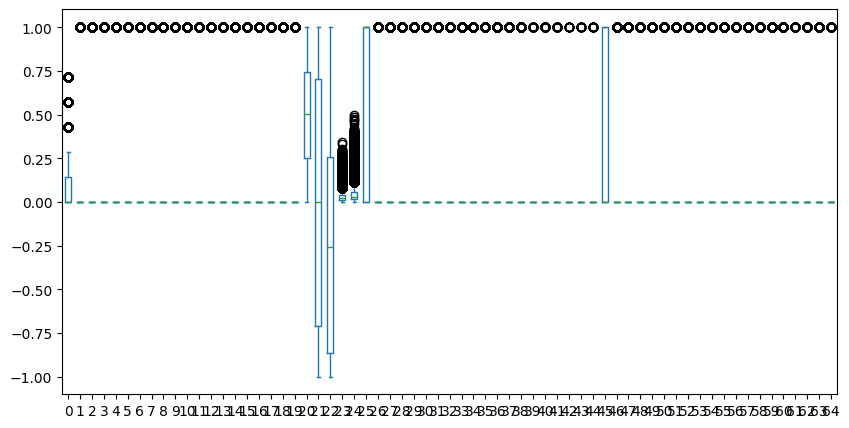

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);


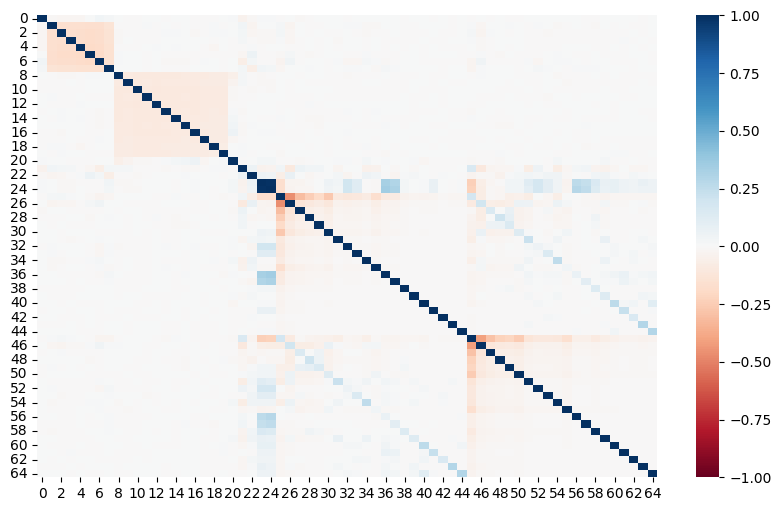

In [80]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');


To conclude, we can can probably also compress our processed data to float32 without loosing too much perf

In [81]:
X_train_processed.dtype


dtype('float64')

In [82]:
print(X_train_processed.nbytes / 1024**2, "MB")


42.09388732910156 MB


In [83]:
# Compress the data a bit
X_train_processed = X_train_processed.astype(np.float32)
X_val_processed = X_val_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)

print(X_train_processed.nbytes / 1024**2, "MB")


21.04694366455078 MB


In [84]:
pd.DataFrame(X_train_processed)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.714286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.714286,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84877,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84878,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84879,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84880,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
pd.DataFrame(X_train_processed).describe().mean(axis=1)


count    84882.000000
mean         0.068347
std          0.203543
min         -0.030769
25%         -0.019855
50%          0.019938
75%          0.060780
max          0.977890
dtype: float64

☝️ The preprocessor outputs a **fixed** number of features (65) that is independent of the training set. 

☝️ The preprocessor is also  **state-less** (i.e it has no `.fit()` method, only a `.transform()`). It can be seen as a *pure function* $f:X \rightarrow X_{processed}$ without an internal state, as opposed to standard scaling for instance, which has to store "X_train standard deviations" as internal states.

These two features will make work much easier for the ML Engineering team to scale preprocessing to hundreds of GBs. 

# 4) Model

## 4.1) Architecture

In [86]:
from tensorflow import keras
from keras import Model, Sequential, layers, regularizers
from keras.callbacks import EarlyStopping


2024-11-02 10:44:49.247264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 10:44:49.876288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-11-02 10:44:49.876361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-02 10:44:49.928899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-

In [87]:
def initialize_model(input_shape:tuple) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l1=0.005)

    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.9))  # use momentum=0 to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model


In [88]:
model = initialize_model(input_shape=X_train_processed.shape[1:])
model.summary()


2024-11-02 10:44:53.112642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-02 10:44:53.113213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-11-02 10:44:53.113429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-11-02 10:44:53.113547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared ob

✅ model initialized
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               6600      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 

In [89]:
learning_rate = 0.0005
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])


In [90]:
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

history = model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
332/332 [==============================] - 3s 6ms/step - loss: 148.9470 - mae: 9.9711 - val_loss: 77.7321 - val_mae: 7.0810
Epoch 2/100
332/332 [==============================] - 2s 5ms/step - loss: 60.2771 - mae: 5.8872 - val_loss: 30.3180 - val_mae: 3.4602
Epoch 3/100
332/332 [==============================] - 2s 5ms/step - loss: 27.4586 - mae: 3.0359 - val_loss: 20.8410 - val_mae: 2.6470
Epoch 4/100
332/332 [==============================] - 2s 5ms/step - loss: 23.8070 - mae: 2.7102 - val_loss: 20.1307 - val_mae: 2.6083
Epoch 5/100
332/332 [==============================] - 2s 5ms/step - loss: 22.8324 - mae: 2.6168 - val_loss: 19.5432 - val_mae: 2.4882
Epoch 6/100
332/332 [==============================] - 2s 5ms/step - loss: 22.0696 - mae: 2.5423 - val_loss: 19.7948 - val_mae: 2.6307
Epoch 7/100
332/332 [==============================] - 2s 5ms/step - loss: 21.3882 - mae: 2.4804 - val_loss: 19.1738 - val_mae: 2.5774
Epoch 8/100
332/332 [==============================] -

## 4.2) Performance evaluation

In [91]:
print("MAE val", round(model.evaluate(X_val_processed, y_val)[1],2), ' $')
print("MAE test", round(model.evaluate(X_test_processed, y_test)[1],2), ' $')
print("MAE test baseline", round(float(baseline_mae_test),2), ' $')


55/55 [==============================] - 0s 2ms/step - loss: 18.5484 - mae: 2.5625
MAE val 2.56  $
56/56 [==============================] - 0s 2ms/step - loss: 19.4681 - mae: 2.7542
MAE test 2.75  $
MAE test baseline 2.88  $


In [92]:
y_pred = model.predict(X_test_processed)


56/56 [==============================] - 0s 2ms/step


(0.0, 60.0)

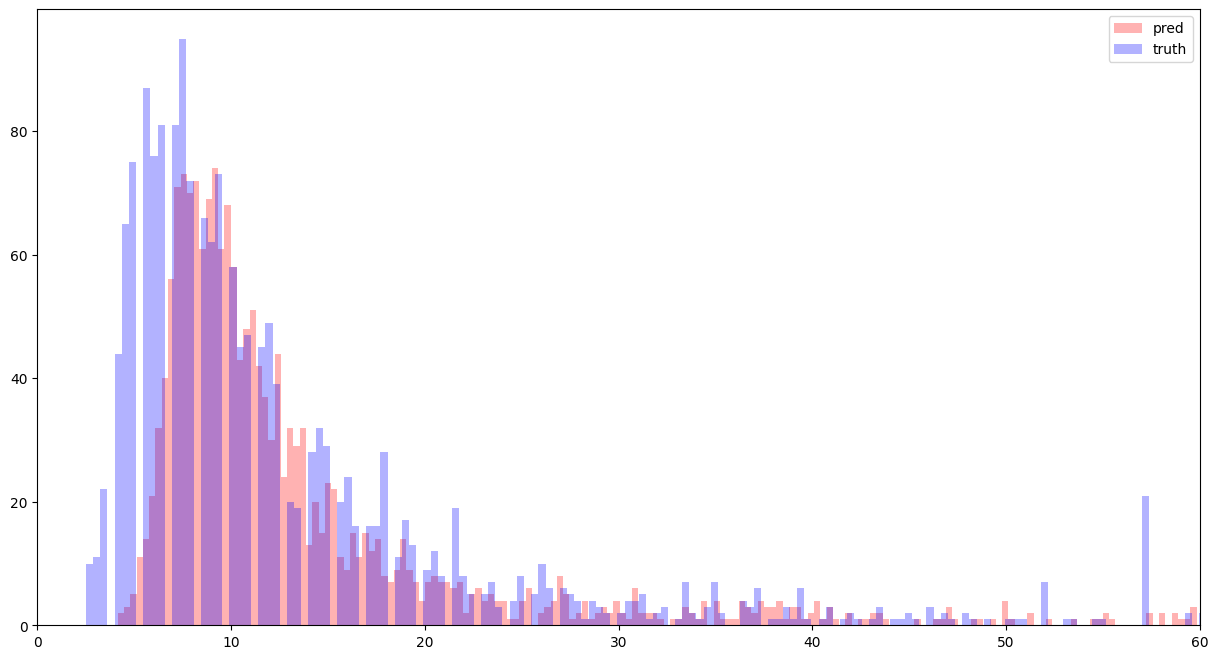

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)

plt.legend()
plt.xlim((0,60))


In [94]:
residuals = y_pred - y_test


In [95]:
residuals.describe()


,fare_amount
count,1767.000000
mean,0.736841
std,4.090422
min,-43.995537
25%,-0.449847
50%,1.433427
75%,2.701017
max,22.136293


(-20.0, 20.0)

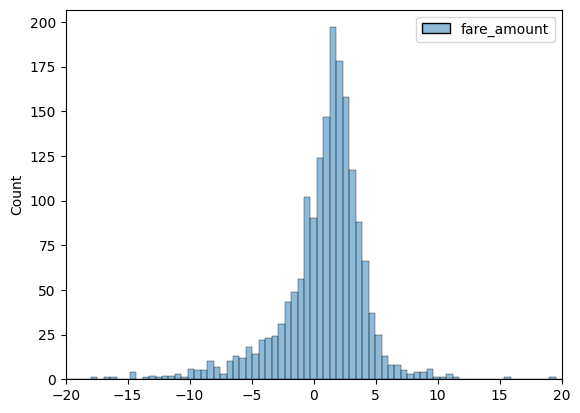

In [96]:
residuals = y_pred - y_test
sns.histplot(residuals)
plt.xlim(xmin=-20, xmax=20)


In [97]:
residuals.sort_values(by='fare_amount')


,fare_amount
90031,-43.995537
89183,-43.955521
90270,-36.432575
90513,-30.097122
89703,-29.640190
...,...
88958,11.569969
88989,15.457911
89996,19.372377
88979,21.551159


Text(0, 0.5, 'residuals')

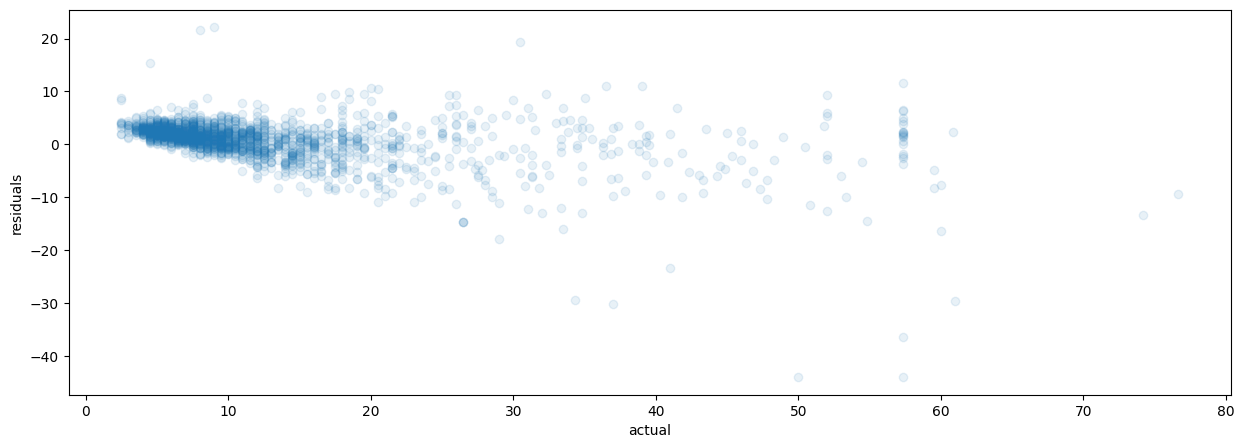

In [98]:
# Residual vs. actual scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=residuals, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('residuals')


Text(0, 0.5, 'residuals')

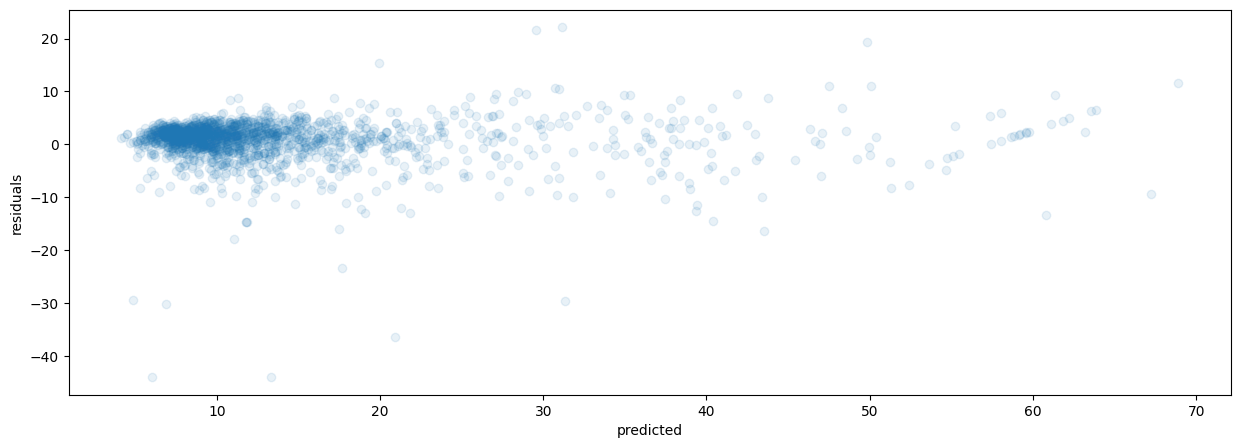

In [99]:
# Residual vs. predicted scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_pred,y=residuals, alpha=0.1)
plt.xlabel('predicted')
plt.ylabel('residuals')


☝️ Our model trained on a limited 60k dataset has an MAE of about 2.5$ per course, compared with a mean course price of 11$.  

A simple linear regression would give us about 3$ of MAE, but the devil lies in the details!

In particular, we're not that good at predicting very long/expensive courses.

# 🧪 Test Your Understanding

❓ Try to answer these questions with your buddy
1. Are you satisfied with the model's performance? 
2. Any ideas to improve it?
3. What is a stateless pipeline (as opposed to a stateful one)?
4. How does an OHEncoder work with fixed column categories?
5. How is the data normalization done in the Neural Net?

<details>
  <summary markdown='span'>💡 Answers</summary>

1. We have a 25% improvement over the linear regression baseline (but we should cross-validate that to be sure). Besides, a 2$ forecast error on taxi courses whose prices also depend on traffic seems close to the irreducible error rate.


2. We could improve model by adding more train data (will test that later). Another promising idea could be to *learn* the embedding of our categorical features (instead of one-hot-encoding them).


3. A stateless pipeline has no real `.fit()` method, only a `.transform()`. 


4. To become stateless, we've hard-coded the `categories` to one-hot encode `OneHotEncoder(categories=categories,...)` and hard-coded the statistical features of each column in our scalers:  `FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))`


5. In the TensorFlow model, notice the `layers.BatchNormalization()` we've added between each dense layer, which normalizes data batch-per-batch! It's a cool feature to help fix vanish gradients during the back-propagation!


</details>

❓ Predict the price for this new course `X_new` below and store the result `y_new` as a `np.ndarray`

In [100]:
X_train.iloc[0:2,:]['pickup_datetime']


69718   2013-07-19 11:29:00+00:00
85925   2014-08-27 20:17:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [101]:
X_new = pd.DataFrame(dict(
    pickup_datetime=[pd.Timestamp("2013-07-06 17:18:00", tz='UTC')],
    pickup_longitude=[-73.950655],
    pickup_latitude=[40.783282],
    dropoff_longitude=[-73.984365],
    dropoff_latitude=[40.769802],
    passenger_count=[1],
))

X_new


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-07-06 17:18:00+00:00,-73.950655,40.783282,-73.984365,40.769802,1


In [102]:
# Compute y_new
pass  # YOUR CODE HERE


In [103]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'notebook',
    subdir='train_at_scale',
    y_new=y_new
)

result.write()
print(result.check())


NameError: name 'y_new' is not defined

Finally, let's run `make test_kitt` so as to allow Kitt to track your progress

In [ ]:
! cd .. && make test_kitt
